<a href="https://colab.research.google.com/github/VMBoehm/N3AS_Project_Malika/blob/main/NeutrinoClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#! ls ./drive/MyDrive/

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_gen = keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/z15',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1534,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False
)

valid_gen = keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/z15',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=1534,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False
)

Found 26970 files belonging to 2 classes.
Using 21576 files for training.
Found 26970 files belonging to 2 classes.
Using 5394 files for validation.


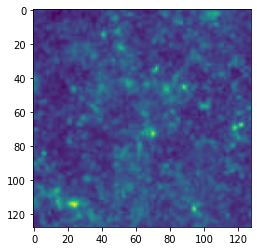

In [6]:
plt.imshow(np.squeeze(next(iter(valid_gen))[0][0]/255))

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False) 

base_model.trainable = False

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

class Gray2VGGInput( Layer ) :
    """Custom conversion layer
    """
    def build( self, x ) :
        self.built = True
        return

    def call( self, x ) :
        rgb_x = K.concatenate( [x,x,x], axis=-1 )
        norm_x = rgb_x
        return norm_x

    def compute_output_shape( self, input_shape ) :
        return input_shape[:3] + (3,)

In [9]:
inputs          = keras.Input(shape=(128, 128,1))
vgg_input_image = Gray2VGGInput( name='gray_to_rgb_norm')(inputs)
x               = vgg_input_image
scale_layer     = keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

x = scale_layer(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(8, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)


In [10]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 gray_to_rgb_norm (Gray2VGGI  (None, 128, 128, 3)      0         
 nput)                                                           
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392 

In [ ]:
# TASK: add validation data (https://keras.io/api/models/model_training_apis/)
model.fit(train_gen, epochs=10, validation_data=valid_gen)

Epoch 1/10
 23/675 [>.............................] - ETA: 27:38 - loss: 0.6909 - binary_accuracy: 0.5774

In [ ]:
model.predict_generator(train_gen, steps=4)